In [22]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from torchinfo import summary
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Resize, InterpolationMode, Lambda
# InterpolationMode.NEAREST

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from  dataloader import get_dataset
from configs.mnist_config import get_config
config = get_config()
N_CATEGORIES = config.data.num_categories
config

data:
  dataset: MNIST
  image_size: 32
  num_categories: 3
  random_flip: true
device: !!python/object/apply:torch.device
- mps
eval:
  batch_size: 1024
model:
  num_scales: 10
  tau_max: 10
  tau_min: 2.0
optim:
  grad_clip: 1.0
  lr: 0.0002
  optimizer: Adam
  warmup: 5000
  weight_decay: 0
seed: 42
training:
  batch_size: 256
  n_epochs: 100

In [15]:
train_ds, val_ds = get_dataset(config)

In [16]:
X, y = next(iter(val_ds))
X.shape

torch.Size([1024, 3, 8, 8])

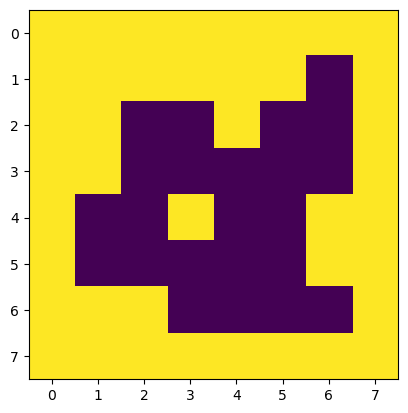

In [17]:
plt.imshow(X[0,0])

In [24]:
from utils import prob_to_logit, log_concrete_sample

In [20]:
x = X[13].clone().unsqueeze(0).repeat(1000,1,1,1)
x.shape

torch.Size([1000, 3, 8, 8])

In [25]:
y[13]

tensor(8)

<AxesSubplot: >

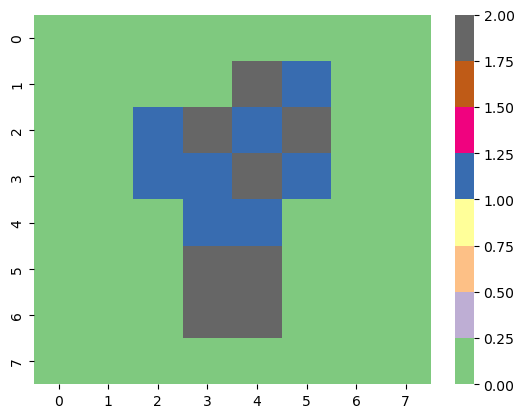

In [26]:
img = prob_to_logit(x).argmax(dim=1)
sns.heatmap(img[1], cmap="Accent")

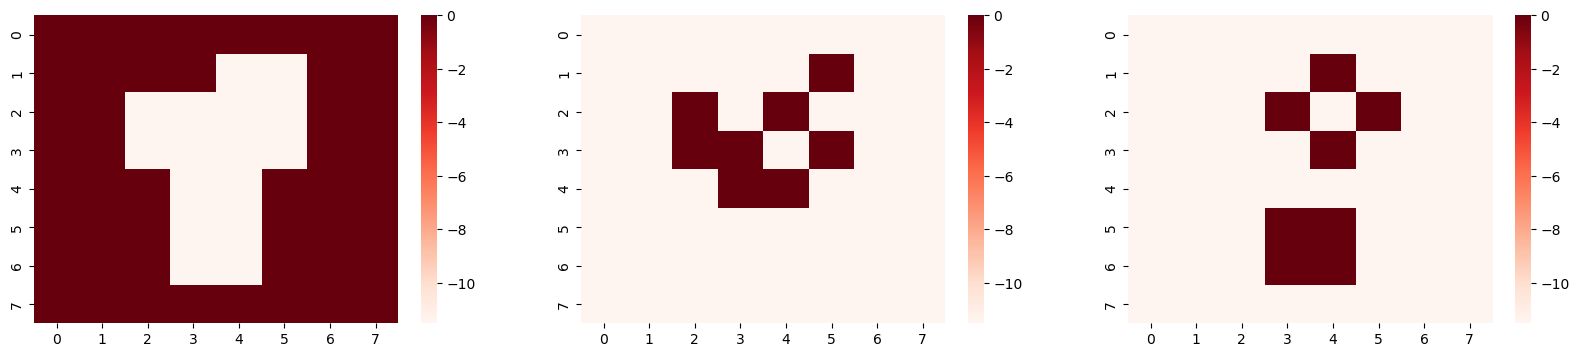

In [30]:
fig, axs = plt.subplots(1, N_CATEGORIES, figsize=(20,4))
x_logit = prob_to_logit(x)
_x = x_logit.softmax(1)
for i in range(N_CATEGORIES):
  sns.heatmap(x_logit[1,i], ax=axs[i], cmap="Reds")

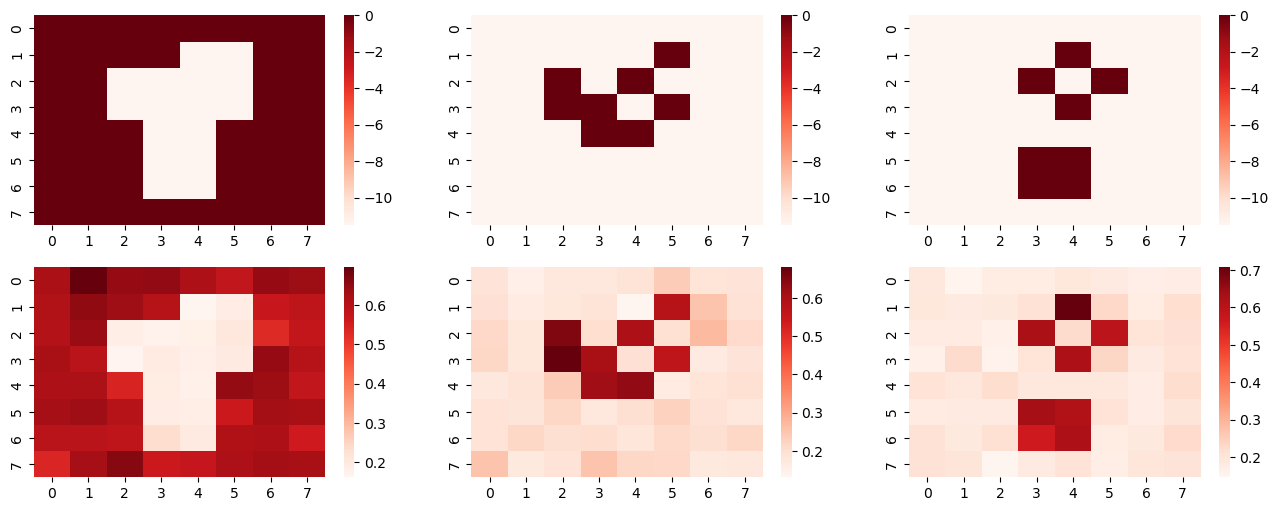

In [32]:
MAX_TAU=10.0
x_logit = prob_to_logit(x)
x_noisy = log_concrete_sample(x_logit, tau=MAX_TAU)
fig, axs = plt.subplots(2,N_CATEGORIES, figsize=(16,6))
for i in range(x_noisy.shape[1]):
  sns.heatmap(x_logit[0,i], ax=axs[0,i], cmap="Reds")
  sns.heatmap(x_noisy[0,i].exp(), ax=axs[1,i], cmap="Reds")

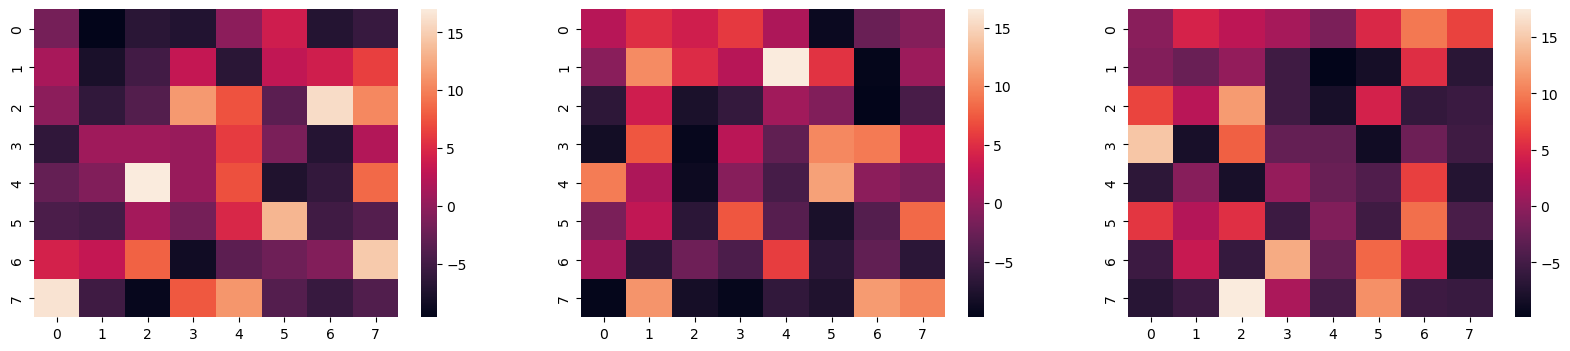

In [34]:
x_grad = log_concrete_grad(x_noisy, x_logit, tau=MAX_TAU)
fig, axs = plt.subplots(1,N_CATEGORIES, figsize=(20,4))
for i in range(N_CATEGORIES):
  sns.heatmap(x_grad[0][i], ax=axs[i])

Note that each pixel is an independent "feature" with its own categories.
It just happens to be that every one has 5 categories
Think abouit how you would convert the image into a tabular form
You would have 5*(28*28) features from which you would have to compute gradients on chunks of five.

In [36]:
x_rec = x_noisy + (x_grad * 1e-2)
# x_rec = torch.softmax(x_rec, dim=1)
x_rec_mean = x_rec.mean(0)
x_rec_probs = (x_rec - torch.logsumexp(x_rec, dim=1, keepdims=True)).mean(0).exp()
x_noisy_mean = x_noisy.mean(0)
x_rec_mean.shape, x_noisy_mean.shape, x_rec.shape

(torch.Size([3, 8, 8]), torch.Size([3, 8, 8]), torch.Size([1000, 3, 8, 8]))

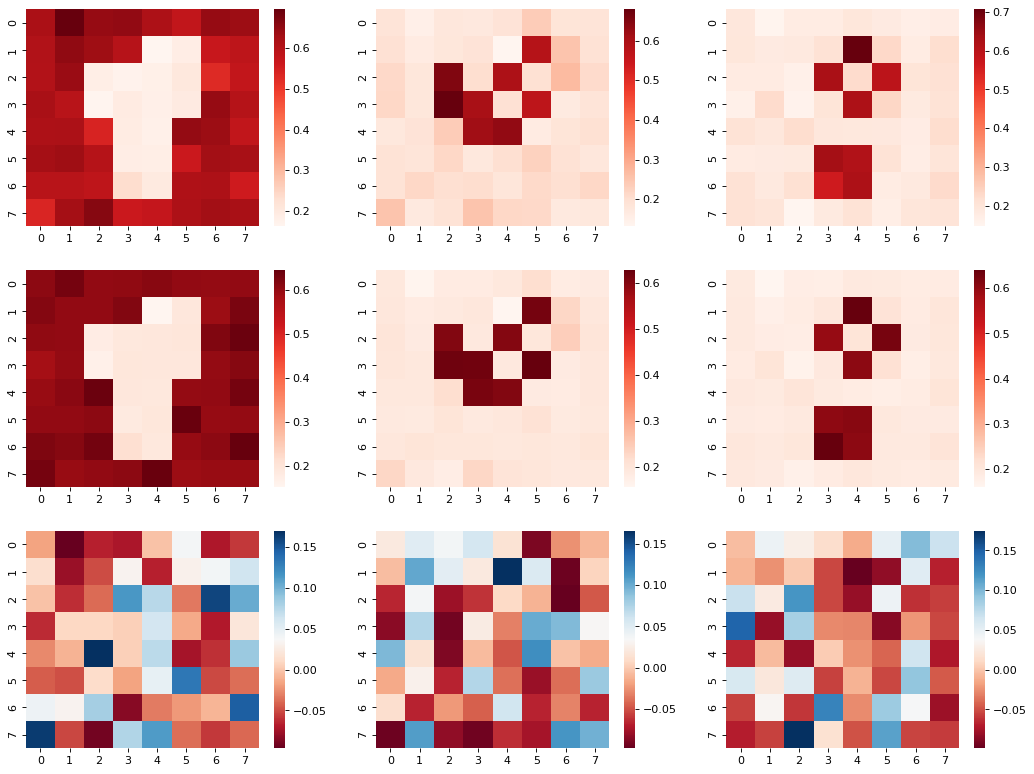

In [37]:
fig, axs = plt.subplots(3, N_CATEGORIES, figsize=(16,12), dpi=80)
for i in range(N_CATEGORIES):
  sns.heatmap(x_noisy[0].exp()[i], ax=axs[0,i], vmin=None, vmax=None, cmap="Reds")
  sns.heatmap(x_rec[0].exp()[i], ax=axs[1,i], vmax=None, cmap="Reds")
  sns.heatmap((x_rec[0][i]-x_noisy[0][i]), ax=axs[2,i], vmin=None, vmax=None, cmap="RdBu")

## Training code

In [39]:
from losses import categorical_dsm_loss, log_concrete_grad

In [47]:
print("Zero-prediction Loss:", categorical_dsm_loss(x_logit, x_noisy, torch.zeros_like(x_grad), tau=MAX_TAU))
print("Random-prediction Loss:", categorical_dsm_loss(x_logit, x_noisy, MAX_TAU+torch.randn_like(x_grad), tau=MAX_TAU))

Zero-prediction Loss: tensor(24.9137)
Random-prediction Loss: tensor(75.4289)


In [101]:
from torch import nn

class GaussianFourierProjection(nn.Module):
    """Gaussian Fourier embeddings for noise levels."""

    def __init__(self, embedding_size=256, scale=1.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embedding_size) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class FiLMBlock(nn.Module):
  def __init__(self, time_dim_sz, num_channels):
    super().__init__()
    self.c = num_channels
    self.dense = nn.Linear(time_dim_sz, num_channels*2)
  
  def forward(self, X, time_emb):
    gamma, beta = torch.split(self.dense(time_emb), (self.c, self.c), dim=1)
    # print(gamma[:,:,None, None].shape)
    return X*gamma[:,:,None, None] + beta[:,:,None, None]

class ResNeXtBlock(nn.Module):
    """The ResNeXt block taken from d2l.ai."""
    def __init__(self, num_channels, time_emb_size, groups=1, bot_mul=1, use_1x1conv=True,
                 strides=1):
        super().__init__()
        
        # !FIXME: Get this from config
        self.act = F.gelu

        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.Conv2d(num_channels, bot_channels, kernel_size=1,
                               stride=1)
        self.norm1 = nn.InstanceNorm2d(bot_channels)
        
        self.conv2 = nn.Conv2d(bot_channels, bot_channels, kernel_size=3,
                               stride=strides, padding=1,
                               groups=bot_channels//groups)
        self.norm2 = nn.InstanceNorm2d(bot_channels)

        self.conv3 = nn.Conv2d(bot_channels, num_channels, kernel_size=1,
                               stride=1)
        self.norm3 = nn.InstanceNorm2d(num_channels)
        
        if use_1x1conv:
            self.conv4 = nn.Conv2d(num_channels,num_channels, kernel_size=1,
                                       stride=strides)
            self.norm4 = nn.InstanceNorm2d(num_channels)
        else:
            self.conv4 = None

        self.film1 = FiLMBlock(time_emb_size, bot_channels)
        self.film2 = FiLMBlock(time_emb_size, bot_channels)
        self.film3 = FiLMBlock(time_emb_size, num_channels)

    def forward(self, X, time_emb):
        Y = self.act(self.norm1(self.conv1(X)))
        Y = self.film1(Y, time_emb)

        Y = self.act(self.norm2(self.conv2(Y)))
        Y = self.film2(Y, time_emb)

        Y = self.norm3(self.conv3(Y))
        Y = self.film3(Y, time_emb)

        if self.conv4:
            X = self.norm4(self.conv4(X))
        
        return self.act(Y + X)

In [102]:
net = ResNeXtBlock(32, 4)
_x = torch.randn(4, 32, 28, 28)

print(net)
summary(net), net(_x, torch.zeros(4,4)).shape

ResNeXtBlock(
  (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
  (norm2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (norm3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv4): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (norm4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (film1): FiLMBlock(
    (dense): Linear(in_features=4, out_features=64, bias=True)
  )
  (film2): FiLMBlock(
    (dense): Linear(in_features=4, out_features=64, bias=True)
  )
  (film3): FiLMBlock(
    (dense): Linear(in_features=4, out_features=64, bias=True)
  )
)


(=================================================================
 Layer (type:depth-idx)                   Param #
 ResNeXtBlock                             --
 ├─Conv2d: 1-1                            1,056
 ├─InstanceNorm2d: 1-2                    --
 ├─Conv2d: 1-3                            320
 ├─InstanceNorm2d: 1-4                    --
 ├─Conv2d: 1-5                            1,056
 ├─InstanceNorm2d: 1-6                    --
 ├─Conv2d: 1-7                            1,056
 ├─InstanceNorm2d: 1-8                    --
 ├─FiLMBlock: 1-9                         --
 │    └─Linear: 2-1                       320
 ├─FiLMBlock: 1-10                        --
 │    └─Linear: 2-2                       320
 ├─FiLMBlock: 1-11                        --
 │    └─Linear: 2-3                       320
 Total params: 4,448
 Trainable params: 4,448
 Non-trainable params: 0
 =================================================================,
 torch.Size([4, 32, 28, 28]))

> ### TODO: Train a proper conditional model and see if you can generate samples via Langevin Dynamics

- [x] Overfit a single batch with only one scale
- [ ] Overfit batch with multiple scales
- [ ] Generate samples

In [103]:
class ScoreNet(nn.Module):
    """The ResNeXt block taken from d2l.ai."""
    def __init__(self, num_channels, nf=32, embedding_size=16):
      super().__init__()

      self.proj = GaussianFourierProjection(embedding_size=embedding_size)
      self.dense = nn.Linear(embedding_size*2, embedding_size*4)
      self.film1 = FiLMBlock(embedding_size*4, nf)

      self.c1 = nn.Conv2d(num_channels, nf, kernel_size=3, stride=1)
      self.resblock1 = ResNeXtBlock(nf, embedding_size*4, groups=2, bot_mul=2)
      self.resblock2 = ResNeXtBlock(nf, embedding_size*4, groups=4, bot_mul=4)
      self.resblock3 = ResNeXtBlock(nf, embedding_size*4, groups=4, bot_mul=4)
      self.resblock4 = ResNeXtBlock(nf, embedding_size*4, groups=2, bot_mul=2)

      self.c2 = nn.ConvTranspose2d(nf, num_channels, kernel_size=3, stride=1)

    def forward(self, x,t):
      temb = self.dense(self.proj(t))
      x = self.film1(self.c1(x), temb)
      # print(x.shape)
      x = self.resblock1(x,temb)
      x = self.resblock2(x,temb)
      x = self.resblock3(x,temb)
      x = self.resblock4(x,temb)
      
      x = self.c2(x)

      return x

In [106]:
nf = 64
model = ScoreNet(N_CATEGORIES, nf, embedding_size=1)
_x = torch.randn(4, N_CATEGORIES, 8, 8)
model, summary(model), model(_x, torch.zeros(4)).shape

(ScoreNet(
   (proj): GaussianFourierProjection()
   (dense): Linear(in_features=2, out_features=4, bias=True)
   (film1): FiLMBlock(
     (dense): Linear(in_features=4, out_features=128, bias=True)
   )
   (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
   (resblock1): ResNeXtBlock(
     (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
     (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
     (norm2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (conv3): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
     (norm3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (conv4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
     (norm4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (film1): FiLMBlock

In [107]:
from tqdm.asyncio import tqdm
def train(model, num_epochs = 10, learning_rate=1e-3,
          name="vanilla", sample_interval=1, dataset=None,
          device="cuda"):

  model.to(device)
  # print(model.is)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                              weight_decay=0.0)
  train_losses = []
  val_losses = []
  
  NUM_SCALES=1
  taus = torch.Tensor(np.linspace(MAX_TAU, 2.0, NUM_SCALES), device="cpu")
  print(taus)
  # train_batch =  [next(iter(train_ds))]
  model.train()
  niters = 0
  pbar = tqdm(range(num_epochs), desc="?")

  for epoch in pbar:
      epoch_loss = 0
      eval_loss = 0
      nbatches = 0

      for img, lab in train_ds:
        # ===================forward=====================
        img_logit = prob_to_logit(img)
        idx = torch.randint(NUM_SCALES, size=(img.shape[0],),
                            dtype=torch.long, device="cpu")
        tau = taus[idx][:,None,None,None]
        x_noisy = log_concrete_sample(img_logit, tau=tau).to(device)
        t = torch.ones(img.shape[0], device=device) * idx.to(device)
        
        scores = model(x_noisy, t)
        loss = categorical_dsm_loss(img_logit.to(device), x_noisy, scores, tau.to(device))
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
        optimizer.step()
        epoch_loss += loss.detach().cpu().data
        train_losses.append(loss.detach().cpu().data)
        nbatches += 1
        niters += 1

        if niters % 10 == 0:
          model.eval()
          eval_batches = 0
          eval_loss = 0
          for img, lab in val_ds:
            img_logit = prob_to_logit(img).to(device)
            idx = torch.randint(NUM_SCALES, size=(img.shape[0],),
                            dtype=torch.long, device=device)
            tau = taus[idx].to(device)[:,None,None,None]
            t = torch.ones(img.shape[0], device=device) * idx
            x_noisy = log_concrete_sample(img_logit, tau=tau)
            scores = model(x_noisy, t)
            loss = categorical_dsm_loss(img_logit, x_noisy, scores, tau)
            eval_loss += loss.data
            eval_batches += 1

          eval_loss /= eval_batches
          pbar.set_description("iter:{} - loss:{:.4f} - val_loss:{:.4f}".format(niters, epoch_loss/nbatches, eval_loss))
          val_losses.append(eval_loss.cpu().numpy())
          model.train()
        
      model.train()
  
  return np.array(train_losses), np.array(val_losses)

## Train model

In [108]:
train_losses, val_losses = train(model, num_epochs=10, learning_rate=3e-4, device="cpu")

tensor([10.])


iter:60 - loss:23.9082 - val_loss:21.9669:   0%|          | 0/10 [00:51<?, ?it/s]


KeyboardInterrupt: 

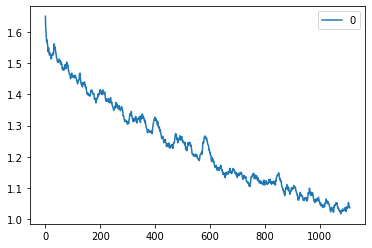

In [ ]:
df = pd.DataFrame(train_losses[1000:])
ema_loss= df.ewm(alpha=0.1).mean()
ema_loss.plot()

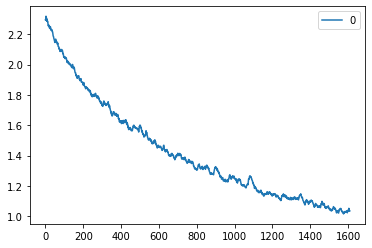

In [ ]:
df = pd.DataFrame(train_losses[500:])
ema_loss= df.ewm(alpha=0.1).mean()
ema_loss.plot()

In [ ]:
x_batch = x_noisy.cuda()

In [ ]:
%%time
# model.cpu()
model.eval()
with torch.no_grad():
  scores = model(x_batch, torch.zeros(x_batch.shape[0], device=x_batch.device)).cpu()
scores.shape

CPU times: user 79.3 ms, sys: 4.87 ms, total: 84.2 ms
Wall time: 84 ms


torch.Size([1000, 3, 8, 8])

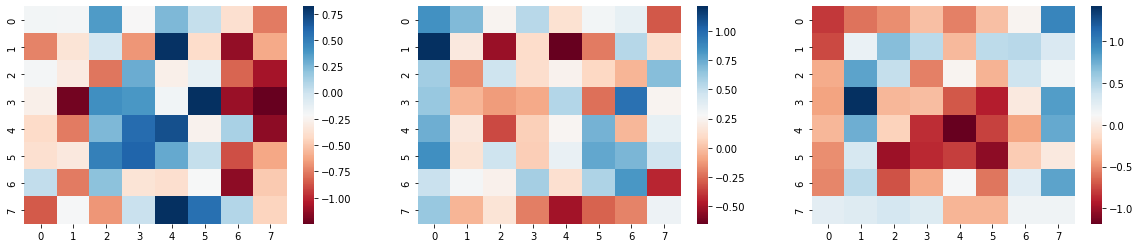

In [ ]:
score_mean = scores.mean(0)
fig, axs = plt.subplots(1,N_CATEGORIES, figsize=(20,4))
for i in range(N_CATEGORIES):
  sns.heatmap(score_mean[i], ax=axs[i], cmap="RdBu")

In [ ]:
x_rec = x_noisy + (scores * 2e-2)
x_rec_mean = x_rec.mean(0)
x_rec_probs = x_rec_mean.softmax(0)

anal_x_rec = x_noisy + (x_grad * 2e-2)
anal_x_rec_probs = anal_x_rec.mean(0).softmax(0)
x_rec_mean.shape, x_noisy_mean.shape, x_rec_probs.shape

(torch.Size([3, 8, 8]), torch.Size([3, 8, 8]), torch.Size([3, 8, 8]))

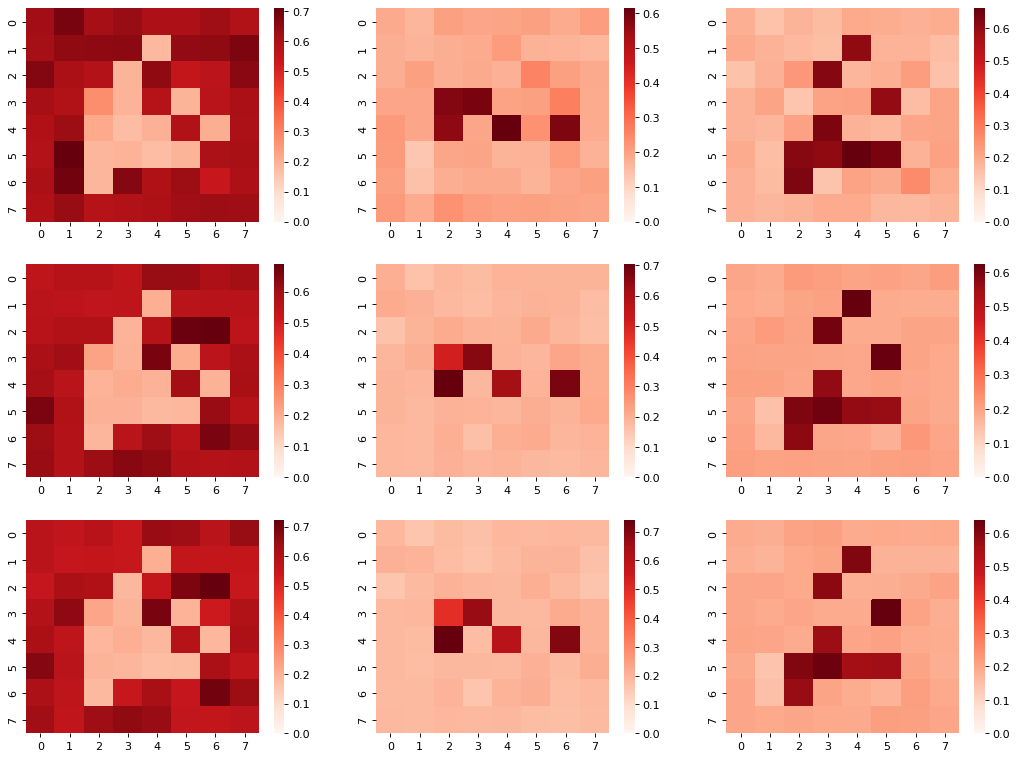

In [ ]:
idx=3
fig, axs = plt.subplots(3, N_CATEGORIES, figsize=(16,12), dpi=80)
for i in range(N_CATEGORIES):
  sns.heatmap(x_noisy[idx].exp()[i], ax=axs[0,i], vmin=0.0, vmax=None, cmap="Reds")
  sns.heatmap(x_rec[idx].exp()[i], ax=axs[1,i], vmin=0.0, cmap="Reds")
  sns.heatmap(anal_x_rec[idx].exp()[i], ax=axs[2,i], vmin=0.0, vmax=None, cmap="Reds")

In [ ]:
torch.sum((x_rec[idx] - anal_x_rec[idx])**2)

tensor(0.1443)

In [ ]:
print(torch.logsumexp(x_logit, dim=1).mean())

tensor(2.0027e-05)


> ### If I subtract LSE everytime, then I am "removing" more than I am updating via score
> ### so it will prolly nullify all my score climbing

In [ ]:
model.eval()
with torch.no_grad():
  x_denoised = x_noisy[:1].clone().cuda()
  for i in range(20):
    # print(torch.logsumexp(x_denoised, dim=1).mean())
    s = model(x_denoised, torch.zeros(1,device="cuda"))
    x_denoised = x_denoised + s * 1e-2

    # Small hack to normalize logits back to conform with
    # concrete distribution as it expects LSE to be zero ideally
    if torch.logsumexp(x_denoised, dim=1).mean().abs() > 1e-5:
      x_denoised -= torch.logsumexp(x_denoised, dim=1)

x_denoised.shape

torch.Size([1, 3, 8, 8])

In [ ]:
torch.linalg.norm(s * 1e-2), torch.logsumexp(x_noisy[:1], dim=1).norm()

(tensor(0.0129, device='cuda:0'), tensor(2.5810e-07))

In [ ]:
torch.logsumexp(x_denoised, dim=1).mean()

tensor(1.3970e-09, device='cuda:0')

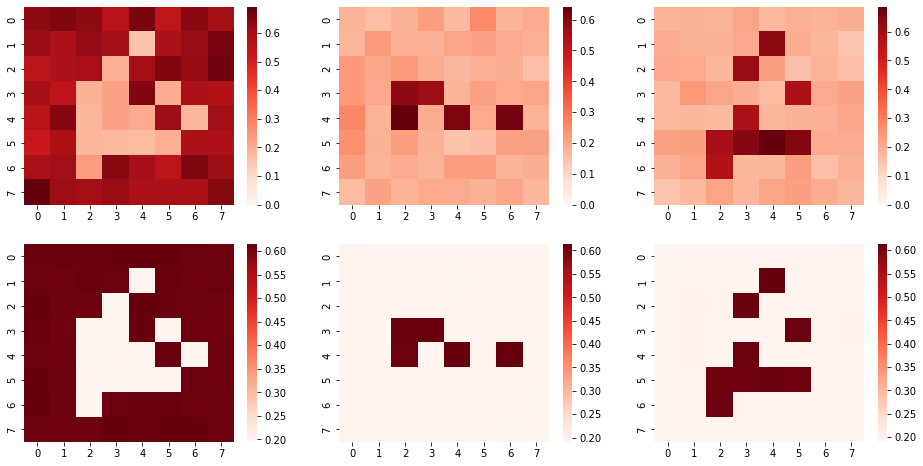

In [ ]:
fig, axs = plt.subplots(2, N_CATEGORIES, figsize=(16,8))
for i in range(N_CATEGORIES):
  sns.heatmap(x_noisy[0].exp()[i], ax=axs[0,i], vmin=0.0, vmax=None, cmap="Reds")
  sns.heatmap(x_denoised[0,i].exp().cpu(), ax=axs[1,i], cmap="Reds")